1. Choose a labeled text dataset used for classification (it could be from Kaggle or any other source). This dataset must have at least one source indicating its business purpose. For example: there could be a scientific article that uses that dataset for something, or there could be clear notes on what is the business application related to the dataset. You must cite the source for this information, and paraphrase it in a sentence or short paragraph. You are not allowed to invent a business case or to use datasets with no business case. This step is important because we want to have meaningful results in situations that are as close to reality as we can get.

# Data Loading and Exploration

In [1]:
import pandas as pd 
import json

data = json.loads(open('OOS Eval Data Full.json').read())

df = pd.DataFrame()

for key in data:
    
    temp_df = pd.DataFrame(data[key], columns=['query', 'category'])
    
    temp_df['key'] = key
    
    df = pd.concat([df, temp_df], ignore_index=True)


df.head()

,query,category,key
0,set a warning for when my bank account starts ...,oos,oos_val
1,a show on broadway,oos,oos_val
2,who has the best record in the nfl,oos,oos_val
3,how do i find the area of a circle,oos,oos_val
4,how many onions do i have on hand,oos,oos_val


In [2]:
df.tail()

,query,category,key
23695,what percentage of species display cold bloode...,oos,oos_train
23696,what does it mean to be an alpha male,oos,oos_train
23697,what animals have alpha males,oos,oos_train
23698,why do males want to be alpha,oos,oos_train
23699,what's the average battery life of an android ...,oos,oos_train


In [3]:
df.shape

(23700, 3)

In [4]:
df['category'].value_counts()

category
oos                1200
order_status        150
goodbye             150
account_blocked     150
what_song           150
                   ... 
reminder            150
change_speed        150
tire_pressure       150
no                  150
card_declined       150
Name: count, Length: 151, dtype: int64

In [5]:
df['key'].value_counts()

key
train        15000
test          4500
val           3000
oos_test      1000
oos_val        100
oos_train      100
Name: count, dtype: int64

In [6]:
df = df.drop('key', axis=1)

In [7]:
df.head()

,query,category
0,set a warning for when my bank account starts ...,oos
1,a show on broadway,oos
2,who has the best record in the nfl,oos
3,how do i find the area of a circle,oos
4,how many onions do i have on hand,oos


In [8]:
df.head()

,query,category
0,set a warning for when my bank account starts ...,oos
1,a show on broadway,oos
2,who has the best record in the nfl,oos
3,how do i find the area of a circle,oos
4,how many onions do i have on hand,oos


2. Define a classification pipeline. Include pre-processing steps and feature engineering, possibly using stemming, lemmatization, removal of particular words, and/or text augmentation with wordnet. In this step, briefly review the models and assumptions. In special, for the bag-of-words model, discuss why it makes sense to use the presence of particular words for that specific classification problem, and try to find counter-examples in which this assumption could be purposefully exploited to confuse the classifier.

# Data Preprocessing and Feature Engineering

In [9]:
def remove_stop_words(X):
    stop_words = open('stop_words.txt').read().split('\n')
    return ' '.join([word for word in X.split() if word not in stop_words])

In [10]:
def lemmatize(X_Plot):
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    X_lemmatized = X_Plot.apply(lambda x: ' '.join([lemmatizer.lemmatize(p) for p in x.lower().split()]))
    return X_lemmatized

In [11]:
def stemmer(X_Plot):
    from nltk.stem import SnowballStemmer
    stemmer = SnowballStemmer("english")
    X_stemmed = X_Plot.apply(lambda x: ' '.join([stemmer.stem(p) for p in x.lower().split()]))
    return X_stemmed

In [12]:
X_clean = df['query'].apply(remove_stop_words)

In [13]:
X_lemma = lemmatize(X_clean)

In [14]:
X_stem = stemmer(X_clean)


In [15]:
X_stem.head()

0    set warn bank account start run low
1                          show broadway
2                        best record nfl
3                        find area circl
4                        mani onion hand
Name: query, dtype: object

In [16]:
X_lemma.head()

0    set warning bank account start running low
1                                 show broadway
2                               best record nfl
3                              find area circle
4                               many onion hand
Name: query, dtype: object

O Bag-of-Words é apropriado neste caso, já que a classificação entre "fora de escopo" e "dentro de escopo" pode depender da presença de palavras-chave específicas que indicam o alinhamento com os tópicos fornecidos. Por exemplo, termos que frequentemente aparecem nas queries dentro do escopo provavelmente não estarão presentes nas queries fora do escopo.

No entanto, o BoW pode ser vulnerável a adversarial attacks. Se uma query fora do escopo incluir muitas palavras relacionadas ao escopo, o modelo pode ser confundido. Por exemplo:

Se uma query for: "ajuda com o tópico de marketing", e "marketing" for um tópico do escopo, o modelo pode classificar incorretamente como "dentro do escopo" mesmo que a consulta não esteja pedindo algo relevante.

# Feature Extraction

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['query'])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['category'])





3. Run and evaluate the classifier. In this step, remember to make diverse shuffles for train and test. If the dataset you chose gives fixed splits for train and test, join them and make the splits yourself. If the dataset is not balanced, remember to use balanced_accuracy_score instead of accuracy_score as an evaluation metric. In this step, identify which words are more important for classification. Discuss the most prominent ones in the context of the actual problem you are dealing with. Do they make sense? Are you classifying coincidences? What is happening here?

# Train-Test Split

In [18]:
from sklearn.model_selection import train_test_split


X = X_lemma
y = df['category'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression())
])

pipeline.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', LogisticRegression())])

In [20]:
from sklearn.metrics import balanced_accuracy_score

y_pred = pipeline.predict(X_test)

balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_acc*100:.2f}%")


Balanced Accuracy: 81.39%


In [21]:
import numpy as np

feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
coefficients = pipeline.named_steps['clf'].coef_[0]


top_features_indices = np.argsort(coefficients)[-10:]  
top_features = feature_names[top_features_indices]

print("Top 10 palavras mais importantes para a classificação:")
for word, coef in zip(top_features, coefficients[top_features_indices]):
    print(f"{word}: {coef:.2f}")


Top 10 palavras mais importantes para a classificação:
zeus: 1.07
make: 1.10
know: 1.11
francisco: 1.12
redrobin: 1.15
burger: 1.25
accept: 1.26
york: 1.31
possible: 1.37
reservation: 12.41


A palavra ```make``` aparece como relevante para a classificação, porem essa é uma palavra de ação bastante genérica. A presença dela como relevante pode ser um sinal de que o classificador está capturando padrões frequentes no texto, mas ela pode não ser boa discriminante entre as classes "dentro do escopo" e "fora do escopo".
Essa palavra pode aparecer em muitos tipos de consultas ("How do I make a reservation?"), o que a torna palavra comum, mas não necessariamente significativa para o verdadeiro objetivo da query.

A palavra ```reservation``` aparece como a mais relevante para o classificador. Isso faz sentido, pois há diversos escopos que incluem a reserva de serviços, como ```book_hotel```, ```cancel_reservation```, ```accept_reservations```, ```confirm_reservation```, ```restaurant_reservation```

Ainda, a palavra ```possible``` aparece como uma das 10 palavras mais relevantes, e ja que é uma palavra muito ampla e genérica, aparecendo em diferentes tipos de queries, sem necessariamente indicar um tópico específico, essa palavra está possivelmente confundindo o classificador.

4. Assess the dataset size, using the strategy of evaluating errors in the train and in the test datasets for various levels of dataset downsampling. According to this assessment, how much room is there to increase your accuracy by increasing the dataset size? Is it feasible given the business case?

# Dataset Size

In [22]:
from sklearn.utils import shuffle

test_error_acc = []
train_error_acc = []
frac = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
min_train_size = 50  

for i in frac:
    df_sample = df.sample(frac=i)
    df_sample = shuffle(df_sample)

    if len(df_sample) * 0.8 < min_train_size:
        print(f"Fracção {i} resulta em um conjunto de treino pequeno demais. Ignorando...")
        continue
    X_train, X_test, y_train, y_test = train_test_split(lemmatize(df_sample['query']), df_sample['category'],test_size=0.2, shuffle=True)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    test_error_acc.append(1-balanced_acc)
    
    y_train_pred = pipeline.predict(X_train)
    balanced_acc_train = balanced_accuracy_score(y_train, y_train_pred)
    train_error_acc.append(1 - balanced_acc_train)  

/Users/sergioramella/Desktop/INSPER/NLP/PI/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/sergioramella/Desktop/INSPER/NLP/PI/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


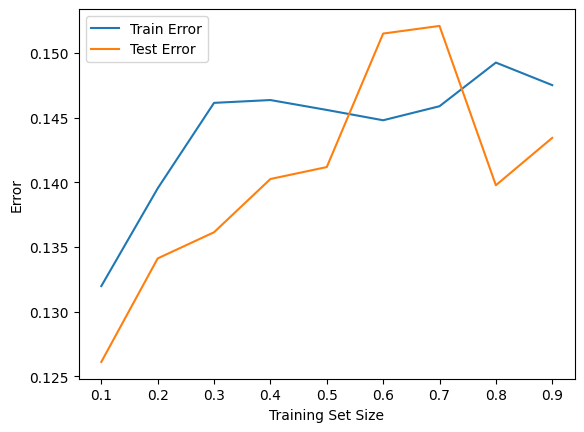

In [26]:
import matplotlib.pyplot as plt

from sklearn.utils import resample

def learning_curve(data, labels, sizes):
    train_errors = []
    test_errors = []
    for size in sizes:
        
        X_sample, _, y_sample, _ = train_test_split(
            data, labels, train_size=size, random_state=42, stratify=labels)
        X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
            X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)
        
        pipeline.fit(X_train, y_train)
        
        
        y_train_pred = pipeline.predict(X_train_s)
        y_test_pred = pipeline.predict(X_test_s)
        train_error = 1 - balanced_accuracy_score(y_train_s, y_train_pred)
        test_error = 1 - balanced_accuracy_score(y_test_s, y_test_pred)
        train_errors.append(train_error)
        test_errors.append(test_error)
    
    plt.plot(sizes, train_errors, label='Train Error')
    plt.plot(sizes, test_errors, label='Test Error')
    plt.xlabel('Training Set Size')
    plt.ylabel('Error')
    plt.legend()
    plt.show()


sizes = np.linspace(0.1, 0.9, 9)

learning_curve(lemmatize(df['query']), df['category'], sizes)


In [ ]:
df_sample.shape

(7167, 2)

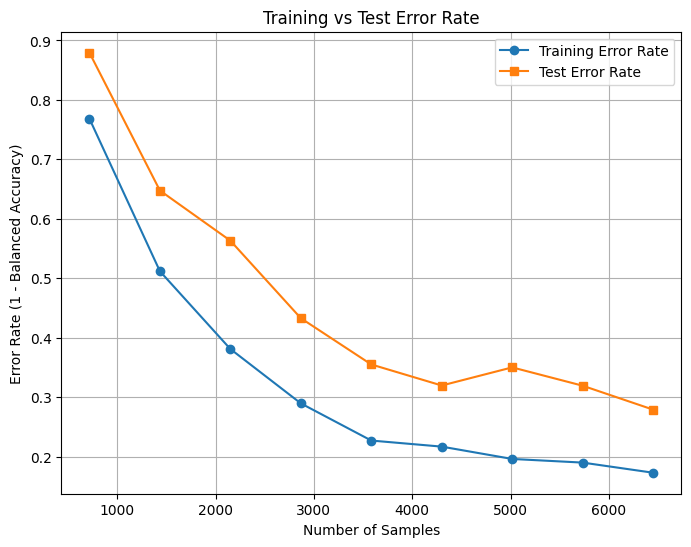

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.utils import shuffle

plt.figure(figsize=(8, 6))
sample_sizes = np.array(frac) * len(df)


plt.plot(sample_sizes[:len(train_error_acc)], train_error_acc, label='Training Error Rate', marker='o')

plt.plot(sample_sizes[:len(test_error_acc)], test_error_acc, label='Test Error Rate', marker='s')

plt.xlabel('Number of Samples')
plt.ylabel('Error Rate (1 - Balanced Accuracy)')
plt.title('Training vs Test Error Rate')
plt.grid(True)
plt.legend()
plt.show()

Use topic models to refine your answers. What does a topic analysis show? Do we have the same error rate over all dataset? Or are there some topics in which classification is more effective? Test a two-layer classifier in which documents are first classified according to their topic, and are then redirected to a classifier focused solely on that specific topic.

# Topic Modeling

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

vectorizer = CountVectorizer(binary=True, stop_words='english')
X = vectorizer.fit_transform(df['query'])
nmf = NMF(n_components=2, random_state=42)
X_nmf = nmf.fit_transform(X)

def print_words_in_topics(nmf_model, vectorizer):
    words = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(nmf_model.components_):
        print(f"Topic {idx}")
        for i in topic.argsort()[-5:]:
            print(words[i])
        print()
    print()
    
print_words_in_topics(nmf, vectorizer)


Topic 0
limit
new
tell
credit
card

Topic 1
change
account
car
know
need




(array([ 6212., 17488.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

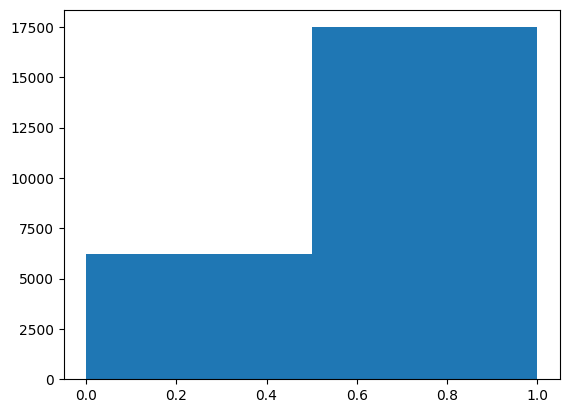

In [37]:
import numpy as np
import matplotlib.pyplot as plt

topic = np.argmax(X_nmf, axis=1)
plt.hist(topic, bins=len(set(topic)))